### Image Classification using Mobilenet on CIFAR10 dataset

The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
The classes/labels are: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

In [2]:
!pip install torch
!pip install efficientnet_pytorch
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet

#Loading the dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=6)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=6)

#To print the labels
print(trainloader.dataset.classes)




Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Importing and compiling the model

In [5]:
#Loading the pretrained Mobilenet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b7')


#Attaching Softmax layer to get probabilities and compiling the model
model.fc = nn.Sequential(nn.Linear(1280, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, 10), nn.LogSoftmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,amsgrad=True,weight_decay=0.000001)

#Model to GPU
model.to(device)
print(device)

Loaded pretrained weights for efficientnet-b7
cuda


### Training the network

In [5]:
import time

running_loss=0
get_ipython().run_line_magic('time', '')
num_epochs=15
for epoch in range(1,num_epochs+1):
    
    for i,data in enumerate(trainloader,0):
        inputs,labels=data[0].to(device),data[1].to(device)
        optimizer.zero_grad()

        output=model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:    # print every 100 mini-batches
            print('[%d %5d] loss: %.3f' % (epoch, i + 1, running_loss / 2000))
            running_loss = 0.0
    




CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs
[1     1] loss: 0.006
[1   101] loss: 0.136
[1   201] loss: 0.085
[1   301] loss: 0.077
[1   401] loss: 0.075
[1   501] loss: 0.066
[1   601] loss: 0.062
[1   701] loss: 0.055
[1   801] loss: 0.054
[1   901] loss: 0.053
[1  1001] loss: 0.049
[1  1101] loss: 0.047
[1  1201] loss: 0.044
[1  1301] loss: 0.046
[1  1401] loss: 0.043
[1  1501] loss: 0.041
[2     1] loss: 0.025
[2   101] loss: 0.037
[2   201] loss: 0.037
[2   301] loss: 0.033
[2   401] loss: 0.034
[2   501] loss: 0.034
[2   601] loss: 0.035
[2   701] loss: 0.034
[2   801] loss: 0.034
[2   901] loss: 0.032
[2  1001] loss: 0.032
[2  1101] loss: 0.032
[2  1201] loss: 0.030
[2  1301] loss: 0.032
[2  1401] loss: 0.031
[2  1501] loss: 0.029
[3     1] loss: 0.018
[3   101] loss: 0.023
[3   201] loss: 0.025
[3   301] loss: 0.021
[3   401] loss: 0.023
[3   501] loss: 0.022
[3   601] loss: 0.023
[3   701] loss: 0.021
[3   801] loss: 0.023
[3   901] loss: 0.023
[3  1001

### Testing the network

In [6]:
correct=0
total=0
start_time,end_time=0,0

with torch.no_grad():
    start_time=time.time()
    for data in testloader:
        
        images,labels=data[0].to(device),data[1].to(device)
        prediction=model(images)
        model.to(device)
        _,predicted=torch.max(prediction.data,1)
        total=total+labels.size(0)
        correct += (predicted == labels).sum().item()
    end_time=time.time()

#Accuracy of the model
accuracy=(100*correct/total)
print('Accuracy of the network on the 10000 test images: %f %%' % accuracy)

#Latency of the model
latency=(end_time-start_time)/10000
print("Latency %f" % latency)



Accuracy of the network on the 10000 test images: 84.960000 %
Latency 0.006552


### To save the model

In [7]:
PATH = 'models/efficientnet.pth'
torch.save(model.state_dict(), PATH)


### Display a few testing results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


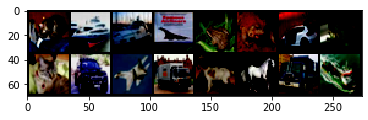

In [ ]:
PATH = 'models/efficientnet.pth'

import numpy as np
classes=('airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))
# Loading model
model.load_state_dict(torch.load(PATH))
model.to('cpu')
outputs=model(images)

_, predicted = torch.max(outputs, 1)
print('Ground Truth: ', ' '.join('%4s' % classes[labels[j]] for j in range(16)))
print('Prediction: ', ' '.join('%4s' % classes[predicted[j]] for j in range(16)))